In [1]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [1]:
# !pip install sentencepiece
# !pip install torch
# !pip install transformers
# !pip install rouge_score

In [2]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import re
import time

import pandas as pd
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, PegasusConfig
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer


In [3]:
#globals
MAX_LENGTH = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [19]:
#dataset and tokenizer building
#load our 10k data into a dataframe
limit = 10000
papers = []
for root, dirs, files in os.walk("./data/mini_10k"):
    for f in files:
        fn = root+"/"+f
        with open(fn) as jsonfile:
            d = json.load(jsonfile)
        papers.append(d)
        
        if len(papers) >= limit:
            break
    if len(papers) >= limit:
        break
df = pd.DataFrame(papers)

In [5]:
#load our rouge scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)

In [6]:
#load our pretrained model
model_name = 'google/pegasus-large'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
config = PegasusConfig.from_pretrained(model_name, output_hidden_states=True, output_attentions=True)  
pt_model = PegasusForConditionalGeneration.from_pretrained(model_name, config=config).to(device)

In [7]:
#example batch (size 1)
#print(df)
batch = tokenizer(df.fulltext[3], truncation=True, padding='longest', return_tensors="pt").to(device)
print(batch.keys())

dict_keys(['input_ids', 'attention_mask'])


In [8]:
#example pretrained generation with keys
out = pt_model.generate(return_dict_in_generate=True, **batch)
print(out.keys())
print(len(out["encoder_hidden_states"]))

odict_keys(['sequences', 'encoder_attentions', 'encoder_hidden_states', 'decoder_attentions', 'cross_attentions', 'decoder_hidden_states'])
17


In [15]:
class AttentionAttention(nn.Module):
    def __init__(self,  
                 vocab_size=32000, 
                 input_size=1024, 
                 target_size=256):
        super(AttentionAttention, self).__init__()
        
        
        #attn head1
        self.ah1_1 = nn.Linear(input_size, target_size)
        self.ah1_2 = nn.Linear(target_size, target_size//2)
        self.ah1_3 = nn.Linear(target_size//2, target_size//4)
        
        #attn head2
        self.ah2_1 = nn.Linear(input_size, target_size)
        self.ah2_2 = nn.Linear(target_size, target_size//2)
        self.ah2_3 = nn.Linear(target_size//2, target_size//4)
        
        #attn head3
        self.ah3_1 = nn.Linear(input_size, target_size)
        self.ah3_2 = nn.Linear(target_size, target_size//2)
        self.ah3_3 = nn.Linear(target_size//2, target_size//4)
        
        #attn head4
        self.ah4_1 = nn.Linear(input_size, target_size)
        self.ah4_2 = nn.Linear(target_size, target_size//2)
        self.ah4_3 = nn.Linear(target_size//2, target_size//4)
 
        #compression layer
        self.fc_comp = nn.Linear(target_size//2, target_size//2)
        
        #output head
        self.fc_out = nn.Linear(target_size//2, vocab_size)
        
        #dropout layer
        self.do = nn.Dropout(p=0.2)
            
        #mapping variable
        self.node2attn = {}
        
    def forward(self, out, print_attn=False):
        
        
        assert(len(out["encoder_attentions"])==16)
        
        #initialize a random tensor as our 'shallow' attn
        shallow_attn1 = torch.rand((1024,1024), requires_grad=True).to(device)
        shallow_attn2 = torch.rand((1024,1024), requires_grad=True).to(device)
        #shallow_attn3 = torch.rand((1024,1024), requires_grad=True).to(device)
        #shallow_attn4 = torch.rand((1024,1024), requires_grad=True).to(device)
        
        #pull only from these attn layers
        self.node2attn = {
            0:shallow_attn1,
            1:shallow_attn2,
            #2:shallow_attn3,
            #4:shallow_attn4,
        }
        
        for i,attn in enumerate(out["encoder_attentions"]):
            if i not in self.node2attn:
                continue
            
            for j,block in enumerate(attn[0]):
                attn = torch.tensor(block).to(device)
                
                #get our shallow attn tensor (right now just noise)
                shallow_attn = self.node2attn[i]
                
                #experiment 0
                #add our attention to the noise
                shallow_attn = shallow_attn.add(attn)
                
                # experiment 1, ab,cd->bc
                #shallow_attn = torch.einsum("ab,cd->bc", shallow_attn, attn)
                
                #experiment 2, ab,cd->ad
                shallow_attn = torch.einsum("ab,cd->ad", shallow_attn, attn)
                
                #optional debug, print attn
                if print_attn:
                    plt.matshow(shallow_attn.cpu().detach().numpy())
                    plt.show()
                
                
                
                #just take the first shallow attn
                #break out from inner loop
                break
                    
        
        
        #values,indices = torch.sort(global_attn)
        
        
        #learn from shallow_attn1
        x1 = F.relu(self.ah1_1(shallow_attn1))
        x1 = F.relu(self.ah1_2(x1))
        x1 = F.relu(self.ah1_3(x1))
        
        #learn from shallow_attn2
        x2 = F.relu(self.ah2_1(shallow_attn2))
        x2 = F.relu(self.ah2_2(x2))
        x2 = F.relu(self.ah2_3(x2))
        
        #learn from shallow_attn3
#         x3 = F.relu(self.ah3_1(shallow_attn3))
#         x3 = F.relu(self.ah3_2(x3))
#         x3 = F.relu(self.ah3_3(x3))
        
#         #learn from shallow_attn4
#         x4 = F.relu(self.ah4_1(shallow_attn4))
#         x4 = F.relu(self.ah4_2(x4))
#         x4 = F.relu(self.ah4_3(x4))
                
        #concatenate all heads
        #print(x1.shape, x2.shape, x3.shape)
        x_concat = torch.cat((x1,x2), 1)
        
        #print(x_concat.shape)

        x = F.relu(self.fc_comp(x_concat))
        
        #add dropout
        x = self.do(x)
        
        #print(x.shape)
        
        #run through our final output layer
        x = F.relu(self.fc_out(x))
        
        #print(x.shape)

        return x

In [16]:
aa = AttentionAttention(vocab_size=tokenizer.vocab_size).to(device)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


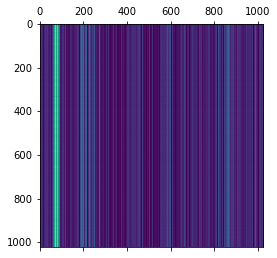

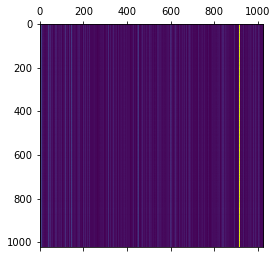

torch.Size([1024, 128])
torch.Size([1024, 96103])


torch.Size([1024, 96103])

In [20]:
o3 = aa.forward(out, print_attn=True)
o3.shape

In [11]:
def summary2tensor(summary, batch_size=1, vocab_size=32000):
    z = torch.zeros(batch_size,vocab_size).to(device)
    for i,wid in enumerate(summary):   
        z[i][wid] = 1.0 
    return z


def pred2tensor(pred):
    ids = []
    for r in pred:
        idx = torch.argmax(r)
        ids.append(idx)
    return torch.tensor(ids)

In [29]:
#load the model from disk
aa = AttentionAttention(vocab_size=tokenizer.vocab_size).to(device)
aa.load_state_dict(torch.load("data/a1_model.state"))
aa.eval()

AttentionAttention(
  (ah1_1): Linear(in_features=1024, out_features=256, bias=True)
  (ah1_2): Linear(in_features=256, out_features=128, bias=True)
  (ah1_3): Linear(in_features=128, out_features=64, bias=True)
  (ah2_1): Linear(in_features=1024, out_features=256, bias=True)
  (ah2_2): Linear(in_features=256, out_features=128, bias=True)
  (ah2_3): Linear(in_features=128, out_features=64, bias=True)
  (ah3_1): Linear(in_features=1024, out_features=256, bias=True)
  (ah3_2): Linear(in_features=256, out_features=128, bias=True)
  (ah3_3): Linear(in_features=128, out_features=64, bias=True)
  (ah4_1): Linear(in_features=1024, out_features=256, bias=True)
  (ah4_2): Linear(in_features=256, out_features=128, bias=True)
  (ah4_3): Linear(in_features=128, out_features=64, bias=True)
  (fc_comp): Linear(in_features=128, out_features=128, bias=True)
  (fc_out): Linear(in_features=128, out_features=96103, bias=True)
  (do): Dropout(p=0.2, inplace=False)
)

In [23]:
#run model in parallel
#aa = nn.DataParallel(aa)

#loss_fn = nn.CrossEntropyLoss()
loss_fn = torch.nn.MSELoss()

for param in aa.parameters():
    param.requires_grad = True

lr = 5.0 # learning rate
optimizer = torch.optim.SGD(aa.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
ntokens = tokenizer.vocab_size
ts = time.time()
for i in range(len(papers)):
    
    batch = tokenizer(df.fulltext[i], truncation=True, padding='longest', return_tensors="pt").to(device)
    
    out = pt_model.generate(return_dict_in_generate=True, **batch)
    
    try:
        pred = aa.forward(out)
    except Exception as e:
        print(e)
        continue
    
    y = tokenizer(df.summary[i], truncation=True, padding='longest', return_tensors="pt").to(device)
    y = y["input_ids"]
    y = summary2tensor(y, batch_size=1024, vocab_size=tokenizer.vocab_size)
    #print(pred.shape, y.shape)
    #print(pred)
    loss = loss_fn(pred, y)
    print("{} {}".format(i, loss.item()))
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        torch.save(aa.state_dict(), "data/a1_model.state")
        print("Iteration {} model saved".format(i))

te = time.time() 
print("Completed in {} seconds".format(int(te-ts)))

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0 0.001580009120516479
Iteration 0 model saved
1 0.0015565167414024472
2 0.0015170465921983123
3 0.0014675320126116276
4 0.0014205168699845672
5 0.001377846347168088
6 0.0013444081414490938
7 0.0013207737356424332
8 0.0013060730416327715
9 0.0012962683103978634
10 0.0012892934028059244
Iteration 10 model saved
11 0.0012844906887039542
12 0.0012806379236280918
13 0.001276897732168436
14 0.0012730202870443463
15 0.001268679858185351
16 0.0012643877416849136
17 0.0012599530164152384
18 0.001254615606740117
19 0.0012492791283875704
20 0.0012442047009244561
Iteration 20 model saved
21 0.0012388152536004782
22 0.0012320675887167454
23 0.0012268932769075036
24 0.0012202226789668202
25 0.001213872921653092
26 0.0012070068623870611
27 0.001200504251755774
28 0.0011927513405680656
29 0.0011856313794851303
30 0.001178156235255301
Iteration 30 model saved
31 0.001170831616036594
32 0.0011619882425293326
33 0.0011538158869370818
34 0.0011456657666713
35 0.0011362724471837282
36 0.001128119183704257

287 9.348693765787175e-07
288 1.422627292413381e-06
289 1.1787483344960492e-06
290 9.450309903513698e-07
Iteration 290 model saved
291 7.214752599793428e-07
292 9.958390592146316e-07
293 9.450309903513698e-07
294 5.792125534753723e-07
295 3.7598007907035935e-07
296 9.551926041240222e-07
297 5.588892690866487e-07
298 1.5039203162814374e-06
299 1.1889100051121204e-06
300 1.4124656217973097e-06
Iteration 300 model saved
301 6.503439067273575e-07
302 5.792125534753723e-07
303 3.2517195336367877e-07
304 9.85677502285398e-07
305 8.129298976200516e-07
306 1.168586663879978e-06
307 1.0466471849213121e-06
308 1.829092184379988e-07
309 1.5039203162814374e-06
310 7.62121771913371e-07
Iteration 310 model saved
311 4.471114323223446e-07
312 2.540406001116935e-07
313 4.6743468828935875e-07
314 9.551926041240222e-07
315 9.450309903513698e-07
316 1.1177785381732974e-06
317 1.077132083082688e-06
318 8.637380233267322e-07
319 8.738996370993846e-07
320 1.6766679209467839e-06
Iteration 320 model saved
321

Iteration 570 model saved
571 1.2702029152933392e-06
572 1.9408701064094203e-06
573 2.001839902732172e-06
574 7.519601581407187e-07
575 1.0364856279920787e-06
576 1.0364856279920787e-06
577 6.706671342726622e-07
578 8.942228646446893e-07
579 4.471114323223446e-07
580 1.107616981244064e-06
Iteration 580 model saved
581 1.7477992741987691e-06
582 9.653542747400934e-07
583 4.1662656258267816e-07
584 1.3718191667067003e-06
585 1.0060007298307028e-06
586 5.284044277686917e-07
587 1.3616576097774669e-06
588 9.450309903513698e-07
589 2.946870836240123e-07
590 1.016162400446774e-06
Iteration 590 model saved
591 9.551926041240222e-07
592 1.4937586456653662e-06
593 9.653542747400934e-07
594 6.198590085659816e-07
595 4.6743468828935875e-07
596 4.877579158346634e-07
597 1.7173143760373932e-06
598 1.3819808373227715e-06
599 8.840612508720369e-07
600 5.792125534753723e-07
Iteration 600 model saved
601 2.1441026092361426e-06
602 1.1482634363346733e-06
603 3.454952093306929e-07
604 9.755158316693269e-

847 1.3616576097774669e-06
848 1.2600413583641057e-06
849 6.096973947933293e-07
850 6.198590085659816e-07
Iteration 850 model saved
851 6.503439067273575e-07
852 8.434147389380087e-07
853 1.1177785381732974e-06
The size of tensor a (1024) must match the size of tensor b (617) at non-singleton dimension 1
855 1.0263239573760075e-06
856 1.3210110410000198e-06
857 4.1662656258267816e-07
858 5.588892690866487e-07
859 2.946870836240123e-07
860 1.077132083082688e-06
Iteration 860 model saved
861 7.926066132313281e-07
862 1.1381018794054398e-06
863 1.4023040648680762e-06
864 9.247077628060651e-07
865 1.5445667713720468e-06
866 7.214752599793428e-07
867 9.043844784173416e-07
868 1.168586663879978e-06
869 9.043844784173416e-07
870 5.487276553139964e-07
Iteration 870 model saved
871 6.706671342726622e-07
872 3.454952093306929e-07
873 1.0466471849213121e-06
874 8.840612508720369e-07
875 6.503439067273575e-07
876 6.808288048887334e-07
877 7.62121771913371e-07
878 1.300687813454715e-06
879 5.080812

1122 8.942228646446893e-07
1123 1.8900619807027397e-06
1124 1.2498796877480345e-06
1125 9.755158316693269e-07
1126 5.38566041541344e-07
1127 1.392142394252005e-06
1128 2.3371734414467937e-07
1129 8.332531251653563e-07
1130 1.1584251069507445e-06
Iteration 1130 model saved
1131 1.5445667713720468e-06
1132 9.653542747400934e-07
1133 5.792125534753723e-07
1134 1.3413342685453244e-06
1135 1.1279402087893686e-06
1136 1.2498796877480345e-06
1137 1.422627292413381e-06
1138 1.1889100051121204e-06
1139 8.434147389380087e-07
1140 1.7274760466534644e-06
Iteration 1140 model saved
1141 9.85677502285398e-07
1142 1.209233232657425e-06
1143 8.434147389380087e-07
1144 2.001839902732172e-06
1145 8.332531251653563e-07
1146 9.85677502285398e-07
1147 1.9103852082480444e-06
1148 1.392142394252005e-06
1149 7.519601581407187e-07
1150 1.300687813454715e-06
Iteration 1150 model saved
1151 3.658184368759976e-07
1152 2.8452546985135996e-07
1153 1.2295564602027298e-06
1154 9.755158316693269e-07
1155 1.59537489707

1395 6.808288048887334e-07
1396 9.958390592146316e-07
1397 1.168586663879978e-06
1398 6.706671342726622e-07
1399 1.8494155256121303e-06
1400 8.738996370993846e-07
Iteration 1400 model saved
1401 1.0568088555373834e-06
1402 8.434147389380087e-07
1403 2.1034561541455332e-06
1404 6.096973947933293e-07
1405 7.519601581407187e-07
1406 2.133941052306909e-06
1407 8.738996370993846e-07
1408 5.893741672480246e-07
1409 8.53576352710661e-07
1410 2.8452546985135996e-07
Iteration 1410 model saved
1411 1.3413342685453244e-06
1412 1.1482634363346733e-06
1413 4.471114323223446e-07
1414 8.738996370993846e-07
1415 8.942228646446893e-07
1416 2.0424863578227814e-06
1417 9.85677502285398e-07
1418 5.792125534753723e-07
1419 1.0466471849213121e-06
1420 5.588892690866487e-07
Iteration 1420 model saved
1421 1.8087689568346832e-06
1422 7.214752599793428e-07
1423 1.1482634363346733e-06
1424 7.722833856860234e-07
1425 7.214752599793428e-07
1426 4.1662656258267816e-07
1427 1.3108494840707863e-06
1428 1.46327374750

1666 1.5344051007559756e-06
1667 1.300687813454715e-06
1668 1.2397180171319633e-06
1669 7.214752599793428e-07
1670 9.653542747400934e-07
Iteration 1670 model saved
1671 6.300206791820528e-07
1672 1.0263239573760075e-06
1673 1.3514959391613957e-06
1674 1.1584251069507445e-06
1675 8.637380233267322e-07
1676 1.1584251069507445e-06
1677 4.1662656258267816e-07
1678 1.6969911484920885e-06
1679 6.909904186613858e-07
1680 5.284044277686917e-07
Iteration 1680 model saved
1681 4.267881763553305e-07
1682 1.2803645859094104e-06
1683 8.23091511392704e-07
1684 8.434147389380087e-07
1685 8.53576352710661e-07
1686 1.016162400446774e-06
1687 5.588892690866487e-07
1688 1.107616981244064e-06
1689 7.722833856860234e-07
1690 9.653542747400934e-07
Iteration 1690 model saved
1691 1.0364856279920787e-06
1692 8.23091511392704e-07
1693 1.3108494840707863e-06
1694 7.316368737519952e-07
1695 1.7173143760373932e-06
1696 1.1787483344960492e-06
1697 9.043844784173416e-07
1698 4.471114323223446e-07
1699 9.95839059214

1937 8.027682838473993e-07
1938 1.0364856279920787e-06
1939 5.792125534753723e-07
1940 1.9002236513188109e-06
Iteration 1940 model saved
1941 9.450309903513698e-07
1942 6.909904186613858e-07
1943 9.653542747400934e-07
1944 1.0466471849213121e-06
1945 8.637380233267322e-07
1946 1.209233232657425e-06
1947 1.4124656217973097e-06
1948 9.653542747400934e-07
1949 1.4835970887361327e-06
1950 7.926066132313281e-07
Iteration 1950 model saved
1951 1.3514959391613957e-06
1952 1.199071562041354e-06
1953 1.2498796877480345e-06
1954 1.2193947895866586e-06
1955 5.284044277686917e-07
1956 5.182428139960393e-07
1957 1.554728441988118e-06
1958 5.487276553139964e-07
1959 1.1279402087893686e-06
1960 2.0628094716812484e-06
Iteration 1960 model saved
1961 4.6743468828935875e-07
1962 9.145460921899939e-07
1963 1.9103852082480444e-06
1964 1.4835970887361327e-06
1965 1.0872937536987592e-06
1966 7.519601581407187e-07
1967 7.722833856860234e-07
1968 5.588892690866487e-07
1969 8.332531251653563e-07
1970 1.2397180

2211 7.722833856860234e-07
2212 7.519601581407187e-07
2213 6.706671342726622e-07
2214 1.0060007298307028e-06
2215 1.1381018794054398e-06
2216 6.198590085659816e-07
2217 1.1177785381732974e-06
2218 1.9611934476415627e-06
The size of tensor a (1024) must match the size of tensor b (985) at non-singleton dimension 1
2220 6.096973947933293e-07
Iteration 2220 model saved
2221 6.401822929547052e-07
2222 7.722833856860234e-07
2223 4.5727304609499697e-07
2224 1.2600413583641057e-06
2225 8.434147389380087e-07
2226 1.0872937536987592e-06
2227 6.605055205000099e-07
2228 7.011520324340381e-07
2229 5.690509397027199e-07
2230 1.0263239573760075e-06
Iteration 2230 model saved
2231 5.284044277686917e-07
2232 1.2600413583641057e-06
2233 1.5953748970787274e-06
2234 3.658184368759976e-07
2235 6.909904186613858e-07
2236 5.284044277686917e-07
2237 1.8494155256121303e-06
2238 1.2702029152933392e-06
2239 9.450309903513698e-07
2240 1.2905261428386439e-06
Iteration 2240 model saved
2241 5.99535781020677e-07
22

2482 6.503439067273575e-07
2483 1.7681225017440738e-06
2484 9.450309903513698e-07
2485 1.3210110410000198e-06
2486 8.942228646446893e-07
2487 1.2600413583641057e-06
2488 8.027682838473993e-07
2489 1.0364856279920787e-06
2490 1.4531121905747568e-06
Iteration 2490 model saved
2491 7.62121771913371e-07
2492 5.893741672480246e-07
2493 9.755158316693269e-07
2494 1.2397180171319633e-06
2495 4.979195296073158e-07
2496 8.23091511392704e-07
2497 1.1787483344960492e-06
2498 8.942228646446893e-07
2499 8.434147389380087e-07
2500 1.0060007298307028e-06
Iteration 2500 model saved
2501 1.615698124624032e-06
2502 6.300206791820528e-07
2503 1.016162400446774e-06
2504 7.011520324340381e-07
2505 6.909904186613858e-07
2506 1.0872937536987592e-06
2507 1.6360213521693368e-06
2508 7.316368737519952e-07
2509 7.417985443680664e-07
2510 5.792125534753723e-07
Iteration 2510 model saved
2511 8.332531251653563e-07
2512 7.417985443680664e-07
2513 5.893741672480246e-07
2514 6.198590085659816e-07
2515 6.3002067918205

2754 5.182428139960393e-07
2755 8.53576352710661e-07
2756 1.331172711616091e-06
2757 8.332531251653563e-07
2758 6.706671342726622e-07
2759 9.043844784173416e-07
2760 9.958390592146316e-07
Iteration 2760 model saved
2761 5.182428139960393e-07
2762 9.247077628060651e-07
2763 9.551926041240222e-07
2764 1.7884457292893785e-06
2765 1.2803645859094104e-06
2766 1.300687813454715e-06
2767 5.893741672480246e-07
2768 8.840612508720369e-07
2769 1.3718191667067003e-06
2770 9.551926041240222e-07
Iteration 2770 model saved
2771 5.690509397027199e-07
2772 1.991678118429263e-06
2773 9.85677502285398e-07
2774 1.4734354181200615e-06
2775 7.62121771913371e-07
2776 9.348693765787175e-07
2777 6.096973947933293e-07
2778 1.1381018794054398e-06
2779 1.6055365676947986e-06
2780 4.5727304609499697e-07
Iteration 2780 model saved
2781 1.016162400446774e-06
2782 5.893741672480246e-07
2783 1.2702029152933392e-06
2784 8.027682838473993e-07
2785 6.808288048887334e-07
2786 1.1482634363346733e-06
2787 1.046647184921312

3028 7.824449994586757e-07
3029 9.348693765787175e-07
3030 1.839253854996059e-06
Iteration 3030 model saved
3031 1.9307084642150585e-07
3032 1.8087689568346832e-06
3033 8.23091511392704e-07
3034 1.6665062503307126e-06
3035 8.332531251653563e-07
3036 1.0669705261534546e-06
3037 1.2498796877480345e-06
3038 5.182428139960393e-07
3039 4.979195296073158e-07
3040 1.920546765177278e-06
Iteration 3040 model saved
3041 8.434147389380087e-07
3042 9.653542747400934e-07
3043 3.9630330661566404e-07
3044 7.113136462066905e-07
3045 4.267881763553305e-07
3046 1.1584251069507445e-06
3047 1.9510316633386537e-06
3048 1.1584251069507445e-06
3049 4.775963020620111e-07
3050 9.551926041240222e-07
Iteration 3050 model saved
3051 1.737637603582698e-06
3052 2.540406001116935e-07
3053 9.653542747400934e-07
3054 8.332531251653563e-07
3055 5.893741672480246e-07
3056 1.4023040648680762e-06
3057 1.6868294778760173e-06
3058 1.2600413583641057e-06
3059 1.5852132264626562e-06
3060 1.4327889630294521e-06
Iteration 3060 

3297 5.588892690866487e-07
3298 1.016162400446774e-06
3299 8.53576352710661e-07
3300 8.840612508720369e-07
Iteration 3300 model saved
3301 9.247077628060651e-07
3302 7.011520324340381e-07
3303 1.5648899989173515e-06
3304 4.471114323223446e-07
3305 8.434147389380087e-07
3306 8.332531251653563e-07
3307 5.588892690866487e-07
3308 9.247077628060651e-07
3309 1.0263239573760075e-06
3310 1.0568088555373834e-06
Iteration 3310 model saved
3311 8.637380233267322e-07
3312 1.2498796877480345e-06
3313 9.755158316693269e-07
3314 9.145460921899939e-07
3315 7.926066132313281e-07
3316 7.417985443680664e-07
3317 1.6969911484920885e-06
3318 1.0060007298307028e-06
3319 1.5445667713720468e-06
3320 1.7173143760373932e-06
Iteration 3320 model saved
3321 8.942228646446893e-07
3322 6.605055205000099e-07
3323 9.551926041240222e-07
3324 1.0263239573760075e-06
3325 9.653542747400934e-07
3326 1.5750516695334227e-06
3327 1.1584251069507445e-06
3328 1.2803645859094104e-06
3329 8.332531251653563e-07
3330 1.0872937536

3571 1.2295564602027298e-06
3572 6.300206791820528e-07
3573 1.6969911484920885e-06
3574 1.4429505199586856e-06
3575 7.011520324340381e-07
3576 1.4531121905747568e-06
3577 1.209233232657425e-06
3578 4.369498185496923e-07
3579 1.8087689568346832e-06
3580 8.942228646446893e-07
Iteration 3580 model saved
3581 4.877579158346634e-07
3582 1.3514959391613957e-06
3583 1.4632737475039903e-06
3584 1.2295564602027298e-06
3585 1.4124656217973097e-06
3586 8.23091511392704e-07
3587 1.4835970887361327e-06
3588 1.8494155256121303e-06
3589 7.214752599793428e-07
3590 1.0364856279920787e-06
Iteration 3590 model saved
3591 8.434147389380087e-07
3592 4.369498185496923e-07
3593 3.5565682310334523e-07
3594 7.113136462066905e-07
3595 2.2050724055588944e-06
3596 6.096973947933293e-07
3597 8.942228646446893e-07
3598 1.0060007298307028e-06
3599 6.605055205000099e-07
3600 1.2498796877480345e-06
Iteration 3600 model saved
3601 8.53576352710661e-07
3602 9.247077628060651e-07
3603 2.154264166165376e-06
3604 6.6050552

3844 8.23091511392704e-07
3845 3.150103395910264e-07
3846 6.503439067273575e-07
3847 1.4429505199586856e-06
3848 1.6258597952401033e-06
3849 1.077132083082688e-06
3850 8.23091511392704e-07
Iteration 3850 model saved
3851 6.706671342726622e-07
3852 4.267881763553305e-07
3853 1.920546765177278e-06
3854 6.808288048887334e-07
3855 8.942228646446893e-07
3856 7.519601581407187e-07
3857 1.300687813454715e-06
3858 1.4531121905747568e-06
3859 5.284044277686917e-07
3860 9.043844784173416e-07
Iteration 3860 model saved
3861 1.4124656217973097e-06
3862 1.4531121905747568e-06
3863 9.85677502285398e-07
3864 1.2702029152933392e-06
3865 7.519601581407187e-07
3866 1.209233232657425e-06
3867 1.646183022785408e-06
3868 1.0872937536987592e-06
3869 1.0364856279920787e-06
3870 1.615698124624032e-06
Iteration 3870 model saved
3871 1.2295564602027298e-06
3872 7.417985443680664e-07
3873 2.022163016590639e-06
3874 1.524243543826742e-06
3875 7.417985443680664e-07
3876 1.6868294778760173e-06
3877 8.63738023326732

4116 1.9307085494801868e-06
4117 7.011520324340381e-07
4118 3.9630330661566404e-07
4119 5.487276553139964e-07
4120 1.392142394252005e-06
Iteration 4120 model saved
4121 8.738996370993846e-07
4122 8.332531251653563e-07
4123 1.107616981244064e-06
4124 8.738996370993846e-07
4125 8.129298976200516e-07
4126 7.519601581407187e-07
4127 5.08081200223387e-07
4128 1.6868294778760173e-06
4129 9.450309903513698e-07
4130 1.4531121905747568e-06
Iteration 4130 model saved
4131 3.454952093306929e-07
4132 7.824449994586757e-07
4133 8.637380233267322e-07
4134 3.9630330661566404e-07
4135 7.926066132313281e-07
4136 6.503439067273575e-07
4137 7.824449994586757e-07
4138 9.958390592146316e-07
4139 1.2803645859094104e-06
4140 6.605055205000099e-07
Iteration 4140 model saved
4141 9.755158316693269e-07
4142 1.0263239573760075e-06
4143 1.3108494840707863e-06
4144 5.487276553139964e-07
4145 7.519601581407187e-07
4146 3.353335671363311e-07
4147 1.0974553106279927e-06
4148 1.168586663879978e-06
4149 1.1482634363346

4390 1.0263239573760075e-06
Iteration 4390 model saved
4391 1.1787483344960492e-06
4392 3.0484869739666465e-07
4393 1.5648899989173515e-06
4394 7.214752599793428e-07
4395 1.7986073999054497e-06
4396 1.077132083082688e-06
4397 1.3819808373227715e-06
4398 9.450309903513698e-07
4399 1.4429505199586856e-06
4400 6.198590085659816e-07
Iteration 4400 model saved
4401 8.129298976200516e-07
4402 8.434147389380087e-07
4403 8.637380233267322e-07
4404 1.8189306274507544e-06
4405 7.011520324340381e-07
4406 1.2600413583641057e-06
4407 3.658184368759976e-07
4408 5.893741672480246e-07
4409 7.214752599793428e-07
4410 4.979195296073158e-07
Iteration 4410 model saved
4411 1.3514959391613957e-06
4412 7.62121771913371e-07
4413 1.554728441988118e-06
4414 5.792125534753723e-07
4415 9.043844784173416e-07
4416 9.85677502285398e-07
4417 1.1177785381732974e-06
4418 4.064649488100258e-07
4419 7.824449994586757e-07
4420 1.4734354181200615e-06
Iteration 4420 model saved
4421 1.300687813454715e-06
4422 8.12929897620

4663 1.2803645859094104e-06
4664 6.300206791820528e-07
4665 8.027682838473993e-07
4666 8.23091511392704e-07
4667 9.653542747400934e-07
4668 1.646183022785408e-06
4669 1.0872937536987592e-06
4670 1.3819808373227715e-06
Iteration 4670 model saved
4671 5.08081200223387e-07
4672 1.0872937536987592e-06
4673 5.588892690866487e-07
4674 1.554728441988118e-06
4675 1.2600413583641057e-06
4676 7.011520324340381e-07
4677 4.877579158346634e-07
4678 7.824449994586757e-07
4679 4.5727304609499697e-07
4680 4.1662656258267816e-07
Iteration 4680 model saved
4681 5.893741672480246e-07
4682 7.824449994586757e-07
4683 9.653542747400934e-07
4684 6.605055205000099e-07
4685 6.401822929547052e-07
4686 1.0872937536987592e-06
4687 9.958390592146316e-07
4688 7.926066132313281e-07
4689 4.369498185496923e-07
4690 1.2193947895866586e-06
Iteration 4690 model saved
4691 1.300687813454715e-06
4692 9.247077628060651e-07
4693 9.247077628060651e-07
4694 1.2905261428386439e-06
4695 1.199071562041354e-06
4696 1.4429505199586

4937 7.824449994586757e-07
4938 1.2193947895866586e-06
4939 9.551926041240222e-07
4940 5.284044277686917e-07
Iteration 4940 model saved
4941 6.909904186613858e-07
4942 1.1584251069507445e-06
4943 7.113136462066905e-07
4944 2.3371734414467937e-07
4945 7.011520324340381e-07
4946 9.958390592146316e-07
4947 8.53576352710661e-07
4948 9.551926041240222e-07
4949 7.214752599793428e-07
4950 8.434147389380087e-07
Iteration 4950 model saved
4951 5.588892690866487e-07
4952 1.4835970887361327e-06
4953 4.6743468828935875e-07
4954 1.1381018794054398e-06
4955 1.3514959391613957e-06
4956 9.755158316693269e-07
4957 8.332531251653563e-07
4958 1.2193947895866586e-06
4959 1.7579608311280026e-06
4960 1.778284172360145e-06
Iteration 4960 model saved
4961 6.503439067273575e-07
The size of tensor a (1024) must match the size of tensor b (877) at non-singleton dimension 1
4963 1.6868294778760173e-06
4964 1.077132083082688e-06
4965 9.958390592146316e-07
4966 1.2397180171319633e-06
4967 9.755158316693269e-07
4968

5209 7.519601581407187e-07
5210 1.3210110410000198e-06
Iteration 5210 model saved
5211 1.3514959391613957e-06
5212 8.53576352710661e-07
5213 9.145460921899939e-07
5214 1.199071562041354e-06
5215 1.2600413583641057e-06
5216 7.926066132313281e-07
5217 1.1889100051121204e-06
5218 3.353335671363311e-07
5219 2.3371734414467937e-07
5220 1.2193947895866586e-06
Iteration 5220 model saved
5221 1.9510316633386537e-06
5222 5.792125534753723e-07
5223 1.199071562041354e-06
5224 1.7477992741987691e-06
5225 1.0364856279920787e-06
5226 5.284044277686917e-07
5227 1.0669705261534546e-06
5228 7.113136746283999e-08
5229 1.971355004570796e-06
5230 7.214752599793428e-07
Iteration 5230 model saved
5231 7.62121771913371e-07
5232 1.2702029152933392e-06
5233 8.637380233267322e-07
5234 8.53576352710661e-07
5235 6.198590085659816e-07
5236 9.958390592146316e-07
5237 6.300206791820528e-07
5238 1.0263239573760075e-06
5239 5.38566041541344e-07
5240 9.247077628060651e-07
Iteration 5240 model saved
5241 7.1131364620669

5482 1.5039203162814374e-06
5483 7.519601581407187e-07
5484 8.129298976200516e-07
5485 1.0263239573760075e-06
5486 1.4023040648680762e-06
5487 1.3108494840707863e-06
5488 1.0263239573760075e-06
5489 6.808288048887334e-07
5490 7.417985443680664e-07
Iteration 5490 model saved
5491 6.300206791820528e-07
5492 1.3718191667067003e-06
5493 1.1787483344960492e-06
5494 1.4835970887361327e-06
5495 9.85677502285398e-07
5496 1.107616981244064e-06
5497 5.182428139960393e-07
5498 3.9630330661566404e-07
5499 6.706671342726622e-07
5500 2.0120014596614055e-06
Iteration 5500 model saved
5501 8.738996370993846e-07
5502 1.2397180171319633e-06
5503 9.653542747400934e-07
5504 8.027682838473993e-07
5505 4.6743468828935875e-07
5506 7.926066132313281e-07
5507 7.62121771913371e-07
5508 1.554728441988118e-06
5509 8.637380233267322e-07
5510 7.722833856860234e-07
Iteration 5510 model saved
5511 3.2517195336367877e-07
5512 4.6743468828935875e-07
5513 1.1381018794054398e-06
5514 1.9002236513188109e-06
5515 1.0568088

5755 1.4023040648680762e-06
5756 1.1787483344960492e-06
5757 1.1381018794054398e-06
5758 3.658184368759976e-07
5759 1.4632737475039903e-06
5760 9.450309903513698e-07
Iteration 5760 model saved
5761 1.3413342685453244e-06
5762 8.129298976200516e-07
5763 7.926066132313281e-07
5764 6.401822929547052e-07
5765 1.300687813454715e-06
5766 4.979195296073158e-07
5767 2.1745875073975185e-06
5768 6.909904186613858e-07
5769 1.0364856279920787e-06
5770 1.4429505199586856e-06
Iteration 5770 model saved
5771 1.2905261428386439e-06
5772 7.011520324340381e-07
5773 6.503439067273575e-07
5774 1.3819808373227715e-06
5775 5.792125534753723e-07
5776 7.722833856860234e-07
5777 8.129298976200516e-07
5778 6.706671342726622e-07
5779 1.2295564602027298e-06
5780 1.3718191667067003e-06
Iteration 5780 model saved
5781 9.551926041240222e-07
5782 8.942228646446893e-07
5783 5.792125534753723e-07
5784 1.8087689568346832e-06
5785 8.027682838473993e-07
5786 1.2600413583641057e-06
5787 1.1482634363346733e-06
5788 9.551926

6029 1.1381018794054398e-06
6030 1.6868294778760173e-06
Iteration 6030 model saved
6031 4.064649488100258e-07
6032 4.877579158346634e-07
6033 1.6563446934014792e-06
6034 1.0263239573760075e-06
6035 1.168586663879978e-06
6036 5.588892690866487e-07
6037 1.1381018794054398e-06
6038 4.6743468828935875e-07
6039 5.690509397027199e-07
6040 3.7598007907035935e-07
Iteration 6040 model saved
6041 6.503439067273575e-07
6042 1.0466471849213121e-06
6043 8.840612508720369e-07
6044 1.1787483344960492e-06
6045 8.23091511392704e-07
6046 1.6868294778760173e-06
6047 5.182428139960393e-07
6048 5.182428139960393e-07
6049 3.658184368759976e-07
6050 8.840612508720369e-07
Iteration 6050 model saved
6051 7.113136462066905e-07
6052 9.145460921899939e-07
6053 1.2193947895866586e-06
6054 1.1381018794054398e-06
6055 7.113136462066905e-07
6056 1.5344051007559756e-06
6057 6.909904186613858e-07
6058 4.6743468828935875e-07
6059 1.2295564602027298e-06
6060 7.722833856860234e-07
Iteration 6060 model saved
6061 1.4124656

6302 8.027682838473993e-07
6303 8.027682838473993e-07
6304 9.043844784173416e-07
6305 1.5445667713720468e-06
6306 1.3718191667067003e-06
6307 3.5565682310334523e-07
6308 9.247077628060651e-07
6309 7.722833856860234e-07
6310 2.235557161611723e-07
Iteration 6310 model saved
6311 7.417985443680664e-07
6312 4.775963020620111e-07
6313 6.909904186613858e-07
6314 1.107616981244064e-06
6315 1.5039203162814374e-06
6316 4.775963020620111e-07
6317 2.022163016590639e-06
6318 9.247077628060651e-07
6319 1.4429505199586856e-06
6320 9.755158316693269e-07
Iteration 6320 model saved
6321 2.6420221388434584e-07
6322 7.214752599793428e-07
6323 4.6743468828935875e-07
6324 6.300206791820528e-07
6325 7.113136462066905e-07
6326 1.7579608311280026e-06
6327 9.348693765787175e-07
6328 1.737637603582698e-06
6329 1.209233232657425e-06
6330 1.4023040648680762e-06
Iteration 6330 model saved
6331 7.62121771913371e-07
6332 8.53576352710661e-07
6333 6.503439067273575e-07
6334 8.942228646446893e-07
6335 9.65354274740093

6574 1.524243543826742e-06
6575 1.0364856279920787e-06
6576 7.824449994586757e-07
6577 6.096973947933293e-07
6578 1.7884457292893785e-06
6579 1.1787483344960492e-06
6580 9.958390592146316e-07
Iteration 6580 model saved
6581 1.4124656217973097e-06
6582 1.2905261428386439e-06
6583 3.5565682310334523e-07
6584 1.6868294778760173e-06
6585 6.706671342726622e-07
6586 6.909904186613858e-07
6587 4.6743468828935875e-07
6588 1.8087689568346832e-06
6589 1.0974553106279927e-06
6590 1.5140818732106709e-06
Iteration 6590 model saved
6591 1.2498796877480345e-06
6592 9.145460921899939e-07
6593 1.920546765177278e-06
6594 1.2600413583641057e-06
6595 8.129298976200516e-07
6596 2.946870836240123e-07
6597 9.145460921899939e-07
6598 6.808288048887334e-07
6599 9.247077628060651e-07
6600 1.0060007298307028e-06
Iteration 6600 model saved
6601 1.9611934476415627e-06
6602 1.0060007298307028e-06
6603 7.316368737519952e-07
6604 6.198590085659816e-07
6605 9.247077628060651e-07
6606 1.2397180171319633e-06
6607 1.2498

6847 9.653542747400934e-07
6848 6.198590085659816e-07
6849 6.808288048887334e-07
6850 7.316368737519952e-07
Iteration 6850 model saved
6851 1.7681225017440738e-06
6852 1.0872937536987592e-06
6853 1.4937586456653662e-06
6854 1.077132083082688e-06
6855 8.129298976200516e-07
6856 1.2600413583641057e-06
6857 1.6055365676947986e-06
6858 6.198590085659816e-07
6859 6.401822929547052e-07
6860 9.348693765787175e-07
Iteration 6860 model saved
6861 1.1381018794054398e-06
6862 1.524243543826742e-06
6863 1.2600413583641057e-06
6864 9.450309903513698e-07
6865 2.032324744050129e-07
6866 9.043844784173416e-07
6867 8.23091511392704e-07
6868 1.4531121905747568e-06
6869 6.706671342726622e-07
6870 8.53576352710661e-07
Iteration 6870 model saved
6871 7.011520324340381e-07
6872 6.706671342726622e-07
6873 1.0872937536987592e-06
6874 1.9307084642150585e-07
6875 7.519601581407187e-07
6876 7.722833856860234e-07
6877 7.62121771913371e-07
6878 2.6420221388434584e-07
6879 6.300206791820528e-07
6880 7.0115203243403

7117 7.926066132313281e-07
7118 6.909904186613858e-07
7119 8.738996370993846e-07
7120 7.316368737519952e-07
Iteration 7120 model saved
7121 5.893741672480246e-07
7122 1.016162400446774e-06
7123 1.7477992741987691e-06
7124 8.027682838473993e-07
7125 1.300687813454715e-06
7126 1.1889100051121204e-06
7127 1.6868294778760173e-06
7128 6.706671342726622e-07
7129 8.738996370993846e-07
7130 8.738996370993846e-07
Iteration 7130 model saved
7131 8.129298976200516e-07
7132 1.4835970887361327e-06
7133 9.247077628060651e-07
7134 6.909904186613858e-07
7135 1.1889100051121204e-06
7136 6.096973947933293e-07
7137 3.861416928430117e-07
7138 1.3514959391613957e-06
7139 1.199071562041354e-06
7140 2.8452546985135996e-07
Iteration 7140 model saved
7141 7.214752599793428e-07
7142 9.348693765787175e-07
7143 6.401822929547052e-07
7144 1.646183022785408e-06
7145 9.551926041240222e-07
7146 6.300206791820528e-07
7147 9.043844784173416e-07
7148 1.0466471849213121e-06
7149 1.0872937536987592e-06
7150 8.637380233267

7391 8.129298976200516e-07
7392 6.300206791820528e-07
7393 1.6665062503307126e-06
7394 1.4632737475039903e-06
7395 7.62121771913371e-07
7396 1.0974553106279927e-06
7397 9.247077628060651e-07
7398 8.332531251653563e-07
7399 8.027682838473993e-07
7400 1.331172711616091e-06
Iteration 7400 model saved
7401 8.434147389380087e-07
7402 1.524243543826742e-06
7403 7.316368737519952e-07
7404 1.1482634363346733e-06
7405 4.775963020620111e-07
7406 1.2702029152933392e-06
7407 1.0263239573760075e-06
7408 1.0060007298307028e-06
7409 8.332531251653563e-07
7410 8.434147389380087e-07
Iteration 7410 model saved
7411 9.85677502285398e-07
7412 5.38566041541344e-07
7413 5.38566041541344e-07
7414 1.2702029152933392e-06
7415 1.0872937536987592e-06
7416 1.2600413583641057e-06
7417 1.4734354181200615e-06
7418 9.043844784173416e-07
7419 7.011520324340381e-07
7420 1.4023040648680762e-06
Iteration 7420 model saved
7421 7.722833856860234e-07
7422 5.487276553139964e-07
7423 6.909904186613858e-07
7424 5.6905093970271

7661 1.1584251069507445e-06
7662 1.199071562041354e-06
7663 7.214752599793428e-07
7664 5.182428139960393e-07
7665 9.348693765787175e-07
7666 7.62121771913371e-07
7667 9.85677502285398e-07
7668 5.182428139960393e-07
7669 8.942228646446893e-07
7670 5.792125534753723e-07
Iteration 7670 model saved
7671 9.348693765787175e-07
7672 1.016162400446774e-06
7673 1.1177785381732974e-06
7674 1.4124656217973097e-06
7675 4.877579158346634e-07
7676 9.653542747400934e-07
7677 7.722833856860234e-07
7678 1.4531121905747568e-06
7679 6.808288048887334e-07
7680 9.958390592146316e-07
Iteration 7680 model saved
7681 9.247077628060651e-07
7682 8.942228646446893e-07
7683 9.043844784173416e-07
7684 1.1381018794054398e-06
7685 1.0568088555373834e-06
7686 8.027682838473993e-07
7687 6.401822929547052e-07
7688 7.926066132313281e-07
7689 8.027682838473993e-07
7690 4.775963020620111e-07
Iteration 7690 model saved
7691 9.85677502285398e-07
7692 9.551926041240222e-07
7693 7.62121771913371e-07
7694 5.690509397027199e-07

7935 9.145460921899939e-07
7936 3.9630330661566404e-07
7937 1.0872937536987592e-06
7938 6.605055205000099e-07
7939 7.417985443680664e-07
7940 6.706671342726622e-07
Iteration 7940 model saved
7941 7.417985443680664e-07
7942 7.62121771913371e-07
7943 7.722833856860234e-07
7944 4.877579158346634e-07
7945 1.0060007298307028e-06
7946 1.4835970887361327e-06
7947 1.524243543826742e-06
7948 1.0974553106279927e-06
7949 1.2905261428386439e-06
7950 7.926066132313281e-07
Iteration 7950 model saved
7951 7.316368737519952e-07
7952 5.893741672480246e-07
7953 1.4734354181200615e-06
7954 7.519601581407187e-07
7955 8.434147389380087e-07
7956 1.2193947895866586e-06
7957 1.1177785381732974e-06
7958 4.877579158346634e-07
7959 7.519601581407187e-07
7960 7.011520324340381e-07
Iteration 7960 model saved
7961 6.096973947933293e-07
7962 4.5727304609499697e-07
7963 1.2295564602027298e-06
7964 6.706671342726622e-07
7965 8.738996370993846e-07
7966 8.738996370993846e-07
7967 1.4429505199586856e-06
7968 9.7551583166

8206 1.3616576097774669e-06
8207 1.554728441988118e-06
8208 1.0568088555373834e-06
8209 1.107616981244064e-06
8210 9.348693765787175e-07
Iteration 8210 model saved
8211 8.23091511392704e-07
8212 1.8290921843799879e-06
8213 1.2397180171319633e-06
8214 1.1787483344960492e-06
8215 8.840612508720369e-07
8216 7.62121771913371e-07
8217 1.016162400446774e-06
8218 1.5140818732106709e-06
8219 1.8595770825413638e-06
8220 1.3210110410000198e-06
Iteration 8220 model saved
8221 8.027682838473993e-07
The size of tensor a (1024) must match the size of tensor b (957) at non-singleton dimension 1
8223 1.554728441988118e-06
8224 5.893741672480246e-07
8225 1.107616981244064e-06
8226 1.0060007298307028e-06
8227 7.824449994586757e-07
8228 8.23091511392704e-07
8229 1.5445667713720468e-06
8230 8.53576352710661e-07
Iteration 8230 model saved
8231 7.214752599793428e-07
8232 1.2295564602027298e-06
8233 5.487276553139964e-07
8234 1.1584251069507445e-06
8235 9.043844784173416e-07
8236 8.332531251653563e-07
8237 9

8475 8.129298976200516e-07
8476 1.8799003100866685e-06
8477 7.722833856860234e-07
8478 9.145460921899939e-07
8479 4.267881763553305e-07
8480 1.2193947895866586e-06
Iteration 8480 model saved
8481 6.096973947933293e-07
8482 8.129298976200516e-07
8483 7.722833856860234e-07
8484 8.53576352710661e-07
8485 1.0466471849213121e-06
8486 9.755158316693269e-07
8487 8.434147389380087e-07
8488 1.168586663879978e-06
8489 6.706671342726622e-07
8490 8.027682838473993e-07
Iteration 8490 model saved
8491 7.011520324340381e-07
8492 8.434147389380087e-07
8493 1.3108494840707863e-06
8494 1.4734354181200615e-06
8495 8.434147389380087e-07
8496 9.348693765787175e-07
8497 4.979195296073158e-07
8498 1.209233232657425e-06
8499 1.1584251069507445e-06
8500 8.23091511392704e-07
Iteration 8500 model saved
8501 1.1787483344960492e-06
8502 8.027682838473993e-07
8503 1.300687813454715e-06
8504 8.027682838473993e-07
8505 1.107616981244064e-06
8506 6.096973947933293e-07
8507 9.85677502285398e-07
8508 6.808288048887334e-

8749 7.316368737519952e-07
8750 2.1441026092361426e-06
Iteration 8750 model saved
8751 9.755158316693269e-07
8752 1.2295564602027298e-06
8753 1.2803645859094104e-06
8754 7.417985443680664e-07
8755 6.605055205000099e-07
8756 6.808288048887334e-07
8757 1.3819808373227715e-06
8758 1.0466471849213121e-06
8759 8.23091511392704e-07
8760 7.519601581407187e-07
Iteration 8760 model saved
8761 4.267881763553305e-07
8762 8.53576352710661e-07
8763 1.4734354181200615e-06
8764 7.417985443680664e-07
8765 1.4531121905747568e-06
8766 6.096973947933293e-07
8767 2.001839902732172e-06
8768 8.53576352710661e-07
8769 1.869738753157435e-06
8770 3.9630330661566404e-07
Iteration 8770 model saved
8771 2.743638276569982e-07
8772 4.5727304609499697e-07
8773 5.588892690866487e-07
8774 3.861416928430117e-07
8775 3.9630330661566404e-07
8776 1.4429505199586856e-06
8777 6.706671342726622e-07
8778 1.0263239573760075e-06
8779 3.150103395910264e-07
8780 7.417985443680664e-07
Iteration 8780 model saved
8781 9.247077628060

9017 1.2193947895866586e-06
9018 6.300206791820528e-07
9019 1.0568088555373834e-06
9020 8.23091511392704e-07
Iteration 9020 model saved
9021 1.0364856279920787e-06
9022 1.107616981244064e-06
9023 9.958390592146316e-07
9024 1.107616981244064e-06
9025 1.077132083082688e-06
9026 1.524243543826742e-06
9027 9.247077628060651e-07
9028 1.1889100051121204e-06
9029 5.588892690866487e-07
9030 6.706671342726622e-07
Iteration 9030 model saved
9031 1.0364856279920787e-06
9032 9.85677502285398e-07
9033 1.2295564602027298e-06
9034 2.0120014596614055e-06
9035 1.8595770825413638e-06
9036 7.113136462066905e-07
9037 5.182428139960393e-07
9038 8.23091511392704e-07
9039 1.0669705261534546e-06
9040 7.519601581407187e-07
Iteration 9040 model saved
9041 7.113136462066905e-07
9042 3.2517195336367877e-07
9043 8.942228646446893e-07
9044 8.23091511392704e-07
9045 1.7477992741987691e-06
9046 9.755158316693269e-07
9047 1.392142394252005e-06
9048 1.0568088555373834e-06
9049 8.129298976200516e-07
9050 1.0568088555373

9289 1.3514959391613957e-06
9290 1.5140818732106709e-06
Iteration 9290 model saved
9291 3.9630330661566404e-07
9292 8.840612508720369e-07
9293 9.043844784173416e-07
9294 8.332531251653563e-07
9295 9.348693765787175e-07
9296 5.284044277686917e-07
9297 1.778284172360145e-06
9298 1.3514959391613957e-06
9299 1.0568088555373834e-06
9300 9.348693765787175e-07
Iteration 9300 model saved
9301 5.99535781020677e-07
9302 2.8452546985135996e-07
9303 1.2193947895866586e-06
9304 1.707152705421322e-06
9305 1.107616981244064e-06
9306 1.7681225017440738e-06
9307 9.043844784173416e-07
9308 5.487276553139964e-07
9309 5.487276553139964e-07
9310 4.775963020620111e-07
Iteration 9310 model saved
9311 4.471114323223446e-07
9312 8.027682838473993e-07
9313 4.5727304609499697e-07
9314 4.877579158346634e-07
9315 1.7986073999054497e-06
9316 6.808288048887334e-07
9317 6.300206791820528e-07
9318 8.942228646446893e-07
9319 8.738996370993846e-07
9320 1.0568088555373834e-06
Iteration 9320 model saved
9321 2.13394105230

9562 8.23091511392704e-07
9563 1.4531121905747568e-06
9564 7.316368737519952e-07
9565 1.168586663879978e-06
9566 7.824449994586757e-07
9567 5.38566041541344e-07
9568 4.1662656258267816e-07
9569 1.554728441988118e-06
9570 4.369498185496923e-07
Iteration 9570 model saved
9571 7.722833856860234e-07
9572 5.893741672480246e-07
9573 1.4734354181200615e-06
9574 1.4734354181200615e-06
9575 1.0974553106279927e-06
9576 9.958390592146316e-07
9577 1.0364856279920787e-06
9578 1.4734354181200615e-06
9579 8.434147389380087e-07
9580 1.2397180171319633e-06
Iteration 9580 model saved
9581 8.738996370993846e-07
9582 6.808288048887334e-07
9583 7.113136462066905e-07
9584 8.129298976200516e-07
9585 8.129298976200516e-07
9586 1.1279402087893686e-06
9587 1.839253854996059e-06
9588 1.6258597952401033e-06
9589 7.417985443680664e-07
9590 1.2803645859094104e-06
Iteration 9590 model saved
9591 1.1177785381732974e-06
9592 1.4531121905747568e-06
9593 2.946870836240123e-07
9594 1.4124656217973097e-06
9595 9.958390592

9835 6.198590085659816e-07
9836 1.2498796877480345e-06
9837 1.0974553106279927e-06
9838 9.85677502285398e-07
9839 1.422627292413381e-06
9840 1.6665062503307126e-06
Iteration 9840 model saved
9841 1.9510316633386537e-06
9842 8.027682838473993e-07
9843 1.1381018794054398e-06
9844 7.011520324340381e-07
9845 4.1662656258267816e-07
9846 1.4429505199586856e-06
9847 6.706671342726622e-07
9848 6.909904186613858e-07
9849 7.417985443680664e-07
9850 6.909904186613858e-07
Iteration 9850 model saved
9851 5.99535781020677e-07
9852 1.0364856279920787e-06
9853 9.958390592146316e-07
9854 1.8900619807027397e-06
9855 7.519601581407187e-07
9856 2.743638276569982e-07
9857 1.2397180171319633e-06
9858 5.08081200223387e-07
9859 1.1279402087893686e-06
9860 1.2905261428386439e-06
Iteration 9860 model saved
9861 1.422627292413381e-06
9862 7.316368737519952e-07
9863 3.9630330661566404e-07
9864 7.722833856860234e-07
9865 1.9815165615000296e-06
9866 7.011520324340381e-07
9867 7.62121771913371e-07
9868 8.94222864644

In [ ]:
#tgt_text = tokenizer.batch_decode(ids, skip_special_tokens=True)
#print(" ".join(tgt_text))

In [24]:
#save the model to disk
torch.save(aa.state_dict(), "data/a1_model.state")

In [28]:
#load the model from disk
a1 = AttentionAttention(vocab_size=tokenizer.vocab_size).to(device)
a1.load_state_dict(torch.load("data/a1_model.state"))
a1.eval()

AttentionAttention(
  (ah1_1): Linear(in_features=1024, out_features=256, bias=True)
  (ah1_2): Linear(in_features=256, out_features=128, bias=True)
  (ah1_3): Linear(in_features=128, out_features=64, bias=True)
  (ah2_1): Linear(in_features=1024, out_features=256, bias=True)
  (ah2_2): Linear(in_features=256, out_features=128, bias=True)
  (ah2_3): Linear(in_features=128, out_features=64, bias=True)
  (ah3_1): Linear(in_features=1024, out_features=256, bias=True)
  (ah3_2): Linear(in_features=256, out_features=128, bias=True)
  (ah3_3): Linear(in_features=128, out_features=64, bias=True)
  (ah4_1): Linear(in_features=1024, out_features=256, bias=True)
  (ah4_2): Linear(in_features=256, out_features=128, bias=True)
  (ah4_3): Linear(in_features=128, out_features=64, bias=True)
  (fc_comp): Linear(in_features=128, out_features=128, bias=True)
  (fc_out): Linear(in_features=128, out_features=96103, bias=True)
  (do): Dropout(p=0.2, inplace=False)
)

In [25]:
def decode_output(pred):
    ids = []
    for x in pred:
        pred_id = torch.argmax(x)
        ids.append(pred_id)
    return ids

In [26]:
#example generate summary from fulltext
summary, fulltext = df.summary[3], df.fulltext[3]
batch = tokenizer(fulltext, truncation=True, padding='longest', return_tensors="pt").to(device)
out = pt_model.generate(return_dict_in_generate=True, **batch)
pred = aa.forward(out)
ids = decode_output(pred)
tgt_text = tokenizer.batch_decode(ids, skip_special_tokens=True)
tgt_text = " ".join(tgt_text)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


NameError: name 'tgt_txt' is not defined

In [27]:
print(tgt_text)

<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

In [30]:
tgt_text = " ".join(tgt_text)

score = scorer.score(tgt_text, summary)
score

{'rouge1': Score(precision=0.029411764705882353, recall=0.0013020833333333333, fmeasure=0.0024937655860349127),
 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0)}